# Preparation

1) Package import 
2) Global variables set

In [1]:
import torch

from data import MakeDataLoader, MakeUnlearnLoader
from models import MNIST_Unet
from loops import TrainLoop, UnlearnLoop


In [2]:
# DataLoader variables
DATASET = "mnist"
BATCH_SIZE = 64
SHUFFLE = True
UNLEARN_LABEL = 1

# Train loop variables
NUM_EPOCHS = 10
RESUME = False

# Device variable
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

# Make dataloader

Sample size:  torch.Size([64, 1, 28, 28])
Labels size:  tensor([8, 2, 5, 8, 2, 3, 3, 9, 0, 4, 1, 1, 1, 3, 1, 5, 7, 9, 6, 5, 8, 0, 5, 4,
        8, 1, 0, 3, 1, 2, 3, 7, 3, 0, 4, 0, 2, 5, 2, 5, 8, 8, 7, 7, 5, 0, 6, 3,
        8, 0, 4, 7, 9, 0, 3, 7, 3, 8, 0, 3, 3, 1, 9, 9])


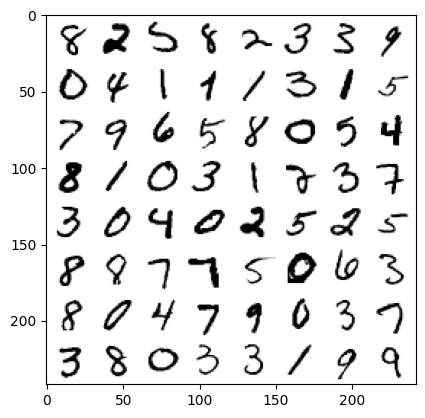

In [3]:
loader_maker = MakeDataLoader(
    ds_name=DATASET,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE
)

loader = loader_maker()


# Build model

In [4]:
model = MNIST_Unet()
print(f"Number of params: {sum(p.numel() for p in model.parameters())}")

Number of params: 1708201


# Unlearn

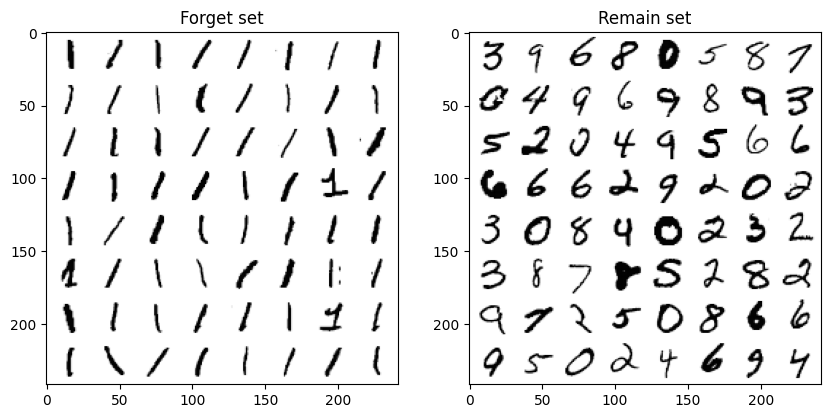

In [5]:
# Dataloader initialization

unlearn_maker = MakeUnlearnLoader(
    ds_name=DATASET,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE,
    label=UNLEARN_LABEL
)

forget_loader, remain_loader = unlearn_maker()

In [6]:
# Unlearning loop
loop = UnlearnLoop(
    data_loaders=(forget_loader, remain_loader),
    model=model,
    label_c=UNLEARN_LABEL,
    device=DEVICE
)

loop()

  0%|          | 0/1000 [00:00<?, ?it/s]

Step 0. Avarage of the last 50 loss values: 0.002811


KeyboardInterrupt: 

# Sample

In [1]:
from diffusers import DDPMScheduler
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import torchvision

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')


In [2]:
model = MNIST_Unet()
model.load_state_dict(torch.load("models/checkpoints/mnist.pt"))

NameError: name 'MNIST_Unet' is not defined

In [ ]:

#@markdown Sampling some different digits:

# Prepare random x to start from, plus some desired labels y
x = torch.randn(80, 1, 28, 28).to(DEVICE)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(DEVICE)
model.to(DEVICE)
# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = model(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')

0it [00:00, ?it/s]

KeyboardInterrupt: 